# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib tabulate`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [1]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from itertools import product
from math import log, sqrt
from tabulate import tabulate
from random import betavariate, normalvariate, random, sample, shuffle, uniform, choice
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [2]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [3]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = good_arms + bad_arms
shuffle(arms)
arms = {arm.arm_id: arm for arm in arms}
arm_ids = list(arms.keys())

In [4]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 6.138576406907423


In [5]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        size = min(size, len(self.arm_ids))
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [6]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalezc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [7]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [8]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 614.0799999999996
random: 285.3


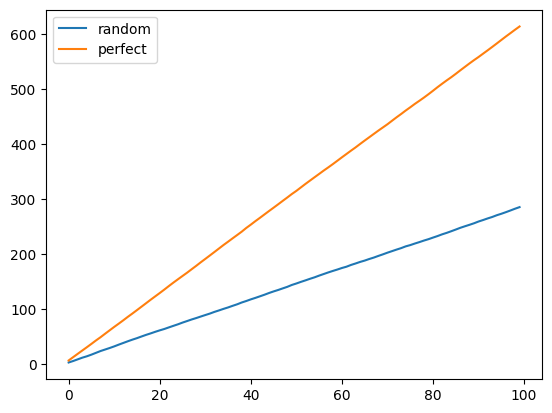

In [9]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 5.96
random: 2.9


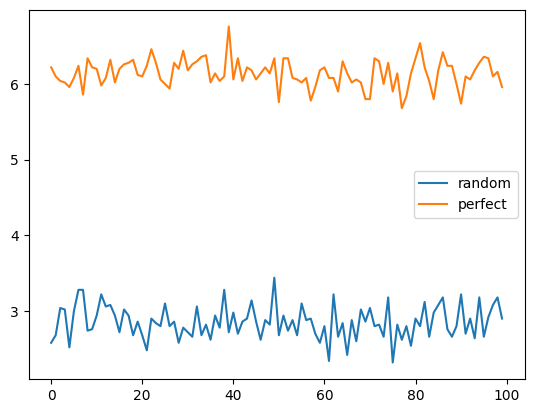

In [10]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [11]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.impressions = {arm_id: 0 for arm_id in arm_ids}
        self.clicks = {arm_id: 0 for arm_id in arm_ids}
        self.ctr = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        recommendations = []

        arms_ctr = [(arm, self.ctr[arm]) for arm in self.arm_ids]
        arms_ctr.sort(key=lambda x: x[1], reverse=True)

        for i in range(size):
            if random() < self.epsilon:
                random_arm = choice(self.arm_ids)
                if random_arm in recommendations:
                    continue
                recommendations.append(random_arm)
            else:
                ith_best_arm, _ = arms_ctr[i]
                if ith_best_arm in recommendations:
                    continue
                recommendations.append(ith_best_arm)
        
        return recommendations
    
    def feedback(self, arm_id, payout):
        self.impressions[arm_id] += 1
        if payout > 0:
            self.clicks[arm_id] += 1
        
        self.ctr[arm_id] = self.clicks[arm_id] / self.impressions[arm_id]

In [12]:
import math

class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.impressions = {arm_id: 0 for arm_id in arm_ids}
        self.clicks = {arm_id: 0 for arm_id in arm_ids}
        self.ctr = {arm_id: 0.0 for arm_id in arm_ids}
        self.total_impressions = 0
    
    def recommend(self, size):
        arms_ucb = [(arm_id, self._optimism(arm_id)) for arm_id in self.arm_ids]
        arms_ucb.sort(key=lambda x: x[1], reverse=True)
        return [arm for arm, _ in arms_ucb[:size]]
    
    def feedback(self, arm_id, payout):
        self.impressions[arm_id] += 1
        self.total_impressions += 1
        self.clicks[arm_id] += payout
        self.ctr[arm_id] = self.clicks[arm_id] / self.impressions[arm_id]

    def _optimism(self, arm_id):
        exploitation = self.ctr[arm_id]
        exploration = math.sqrt((2 * math.log((self.total_impressions+1))) / (self.impressions[arm_id]+1))
        return exploitation + self.optimism_weight * exploration

In [13]:
import numpy as np

class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}  
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size=1):
        samples = {}
        for arm_id in self.arm_ids:
            samples[arm_id] = np.random.beta(self.a[arm_id], self.b[arm_id])
        
        recommended_arms = sorted(samples, key=samples.get, reverse=True)[:size]
        return recommended_arms

    def feedback(self, arm_id, payout):
        if payout > 0:
            self.a[arm_id] += self.reward_multiplier * payout 
        else:
            self.b[arm_id] += self.regret_multiplier * (1 - payout)  

## Część 3. - zgrubne porównanie bandytów

In [14]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
eGreedyBandits = [EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]]
ucbBandits = [UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]]
tsBandits = [ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 10, 50], [1, 10, 50])]

for b in [eGreedyBandits, ucbBandits, tsBandits]:
    bandits.extend(b)

In [15]:
def get_results(bandits):
    runner = Runner(arms, bandits)
    return runner, runner.simulate(runs, epochs, recommendation_size)

runner, results = get_results(bandits)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_10
Simulating: ts_1_50
Simulating: ts_10_1
Simulating: ts_10_10
Simulating: ts_10_50
Simulating: ts_50_1
Simulating: ts_50_10
Simulating: ts_50_50


Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_10
Simulating: ts_1_50
Simulating: ts_10_1
Simulating: ts_10_10
Simulating: ts_10_50
Simulating: ts_50_1
Simulating: ts_50_10
Simulating: ts_50_50

Aggregated results:

perfect: 6.48
ts_1_1: 6.32
ts_10_1: 6.32
ts_1_50: 5.94
ts_10_10: 5.92
ts_1_10: 5.82
egreedy_0.01: 5.78
egreedy_0.05: 5.78
egreedy_0.1: 5.78
ucb_1: 5.74
ts_10_50: 5.72
egreedy_0.25: 5.36
ts_50_1: 5.32
ucb_0.1: 5.24
ts_50_10: 5.08
ts_50_50: 5.04
ucb_0.01: 4.28
ucb_10: 3.18
random: 2.86


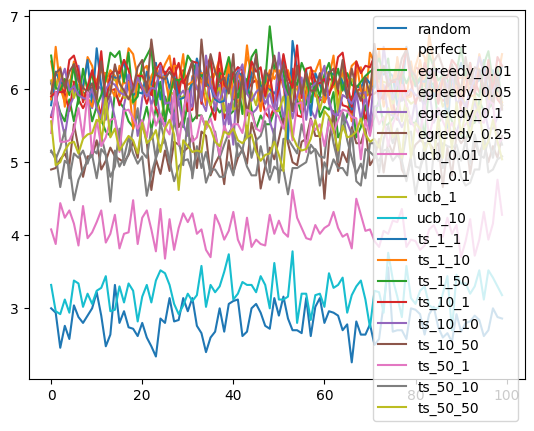

In [16]:
def plot_bandits_results(bandits, mode='average' ):
    runner, results = get_results(bandits)
    runner.plot_results(results, runs, epochs, mode=mode)

plot_bandits_results(bandits);

Simulating: ts_1_1
Simulating: ts_1_10
Simulating: ts_1_50
Simulating: ts_10_1
Simulating: ts_10_10
Simulating: ts_10_50
Simulating: ts_50_1
Simulating: ts_50_10
Simulating: ts_50_50

Aggregated results:

ts_10_10: 6.42
ts_1_1: 6.12
ts_1_50: 6.12
ts_10_50: 6.04
ts_1_10: 5.98
ts_10_1: 5.94
ts_50_1: 5.78
ts_50_50: 5.5
ts_50_10: 5.16


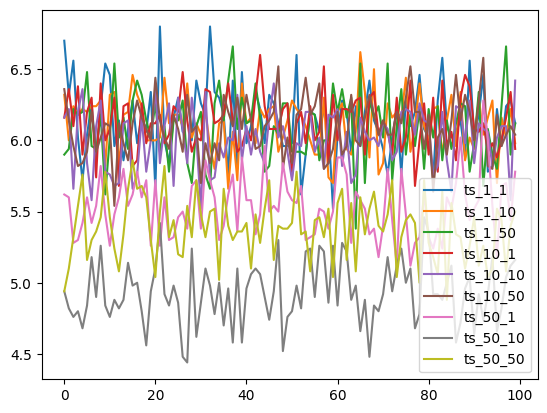

In [17]:
plot_bandits_results(tsBandits)


Aggregated results:

perfect: 614.4399999999997
ts_10_1: 605.5800000000002
ts_1_50: 601.4599999999998
ts_10_50: 600.7399999999998
ts_1_10: 598.0800000000003
ts_1_1: 594.4000000000002
egreedy_0.1: 565.0200000000001
egreedy_0.05: 559.6800000000001
ts_10_10: 550.98
ts_50_1: 542.3399999999999
ucb_1: 536.1399999999999
ts_50_50: 532.26
egreedy_0.25: 522.4200000000002
ucb_0.1: 511.3800000000001
egreedy_0.01: 504.28
ts_50_10: 492.48
ucb_0.01: 411.4000000000003
ucb_10: 304.3
random: 283.98000000000013


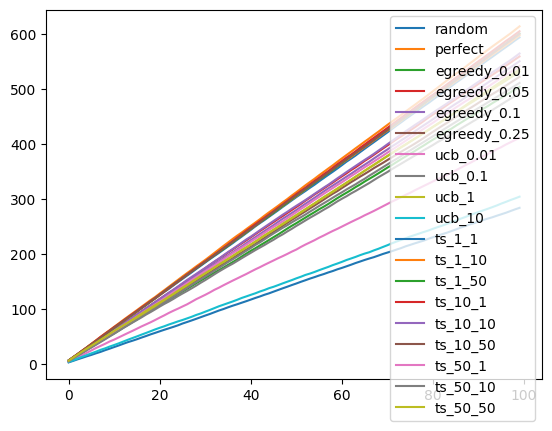

In [18]:
runner.plot_results(results, runs, epochs, mode='cumulative')

Simulating: ts_1_1
Simulating: ts_1_10
Simulating: ts_1_50
Simulating: ts_10_1
Simulating: ts_10_10
Simulating: ts_10_50
Simulating: ts_50_1
Simulating: ts_50_10
Simulating: ts_50_50

Aggregated results:

ts_1_10: 618.7599999999996
ts_1_1: 615.4600000000003
ts_10_1: 614.8999999999999
ts_1_50: 611.74
ts_10_50: 611.5600000000001
ts_10_10: 596.6400000000001
ts_50_1: 583.1199999999999
ts_50_50: 530.34
ts_50_10: 493.5


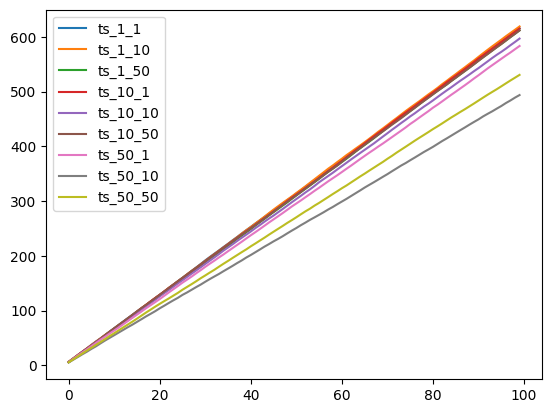

In [19]:
plot_bandits_results(tsBandits, mode='cumulative')

In [20]:
raise Exception("End of part 3")

Exception: End of part 3

## Część 4. - dokładne porównanie bandytów

In [38]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    return len([arm for arm in recommendation if arm.arm_id.startswith('good')])

all_relevant = relevant(arms.values())

In [39]:
# obliczmy precision@k i recall@k (na bazie funkcji relevant())
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    raise NotImplementedError()

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    raise NotImplementedError()

In [ ]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

In [ ]:
class TestEntry():
    def __init__(self, bandit_name: str, k: int, precision: float, recall: float):
        self.bandit_name = bandit_name
        self.k = k
        self.precision = precision
        self.recall = recall
    
    def tuple(self):
        return (self.bandit_name, self.k, self.precision, self.recall)


def print_test_results(entries: List[TestEntry]):
    data = sorted(sorted([e.tuple() for e in entries], key=lambda e: e[1]), key=lambda e: e[0])
    headers = ('bandit', 'k', 'precision@k', 'recall@k')
    return tabulate(data, headers, tablefmt='github')

In [ ]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
tesing_bandits = #...
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10
# miejsce na wyniki
results = []

# dla kazdego bandyty - genetujemy `samples` rekomendacji, liczymy precision i recall, zapisujemy srednie wartosci
# powtarzamy dla kazdego k

# uwaga! przed przeprowadzeniem porownania, bandyci musza sie nauczyc
# pamietaj o uruchomieniu `runner.simulate()` w poprzedniej czesci

raise NotImplementedError()

print_test_results(results)